# Consigna:
- Implementar la función `create_gauss_filter (h, w, k_size , sigma)` para crear filtros gaussianos para filtrado espectral.
Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.
    - Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.
    - Usando el método descripto en el paper Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
    - Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape from focus”


# Resolución
## Importación de librerías públicas

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

%matplotlib inline

## Importación de módulos codeados en el repo

In [3]:
# Set path to reach src folder
import sys

sys.path.append("../")

In [4]:
from src.filter_utils import create_gauss_filter

### Creacion de filtros gaussianos y su representación

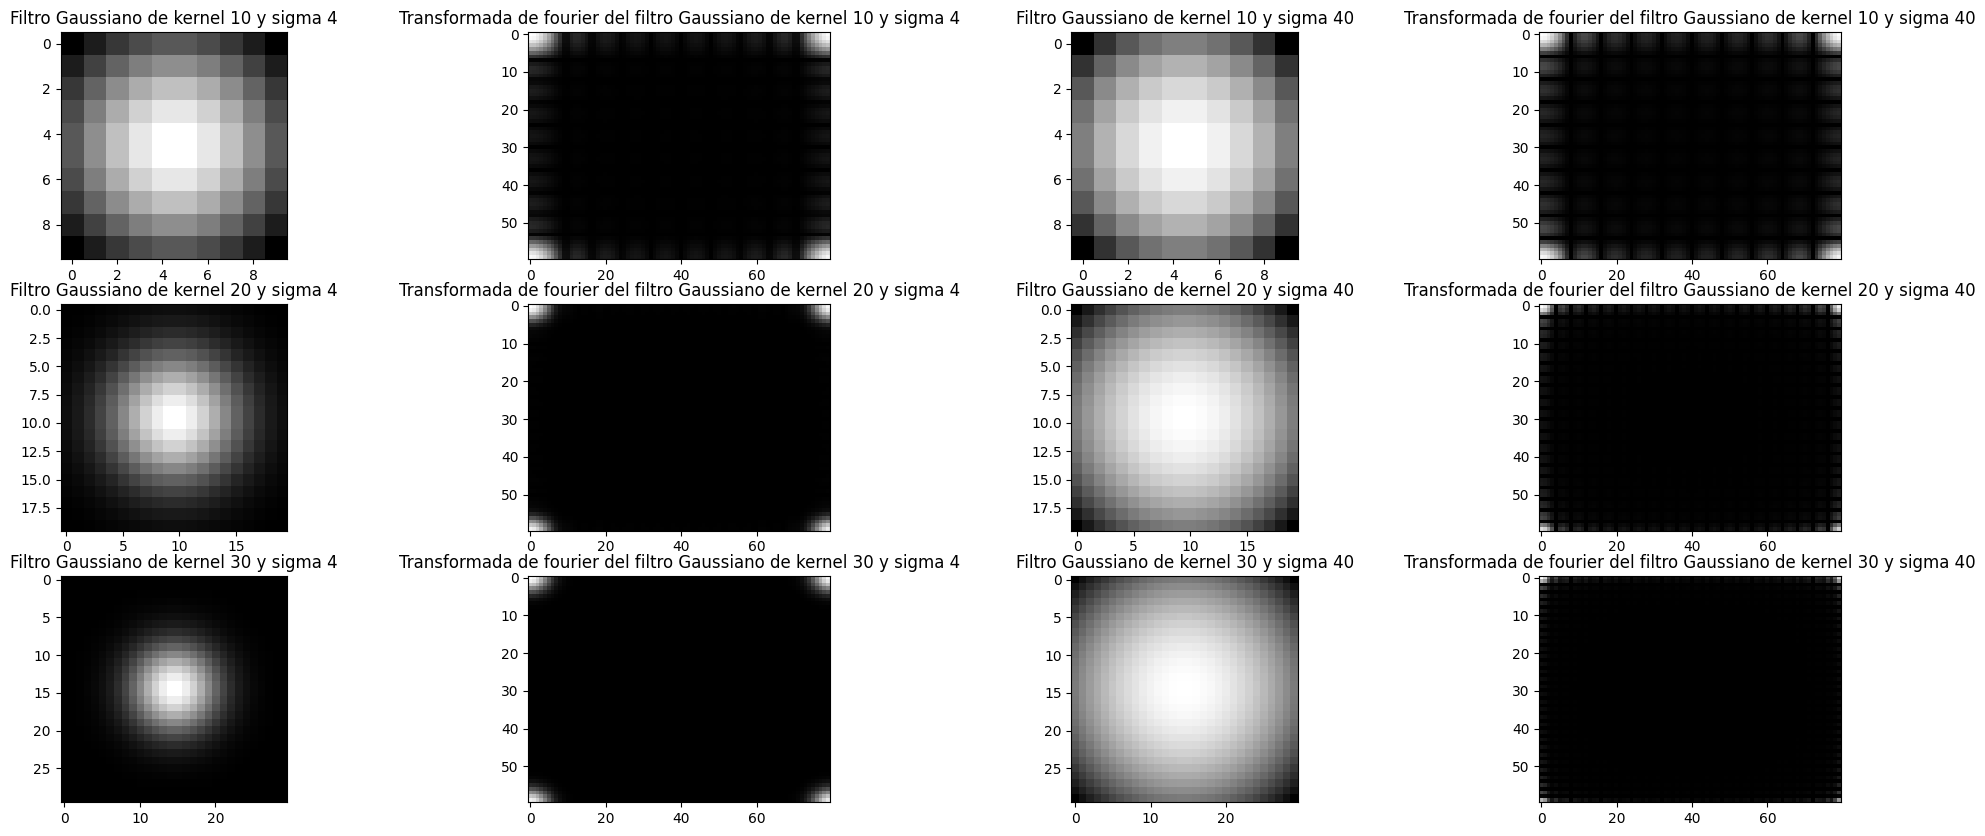

In [15]:
kernel_sizes = [10, 20, 30]
sigmas = [4, 40]
img_height = 60
img_width = 80

# Show images in single row
fig, axes = plt.subplots(3, 4, figsize=(25, 10))

for i, k in enumerate(kernel_sizes):
    for j, s in enumerate(sigmas):
        gauss_kernel, gauss_fft = create_gauss_filter(
            img_height, img_width, k, s
        )
        axes[i][j*2].imshow(gauss_kernel, cmap="gray")
        axes[i][j*2].set_title(f"Filtro Gaussiano de kernel {k} y sigma {s}")

        axes[i][j*2+1].imshow(np.log(1 + np.abs(gauss_fft)), cmap="gray")
        axes[i][j*2+1].set_title(
            f"Transformada de fourier del filtro Gaussiano de kernel {k} y sigma {s}"
        )